In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [21]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta, datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
base.classes.keys()


['station', 'measurement']

In [7]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
max_date = session.query(measurement.date).order_by(measurement.date.desc()).limit(1).scalar()

print(max_date)

2017-08-23


Start: 2016-08-23 00:00:00; End: 2017-08-23 00:00:00


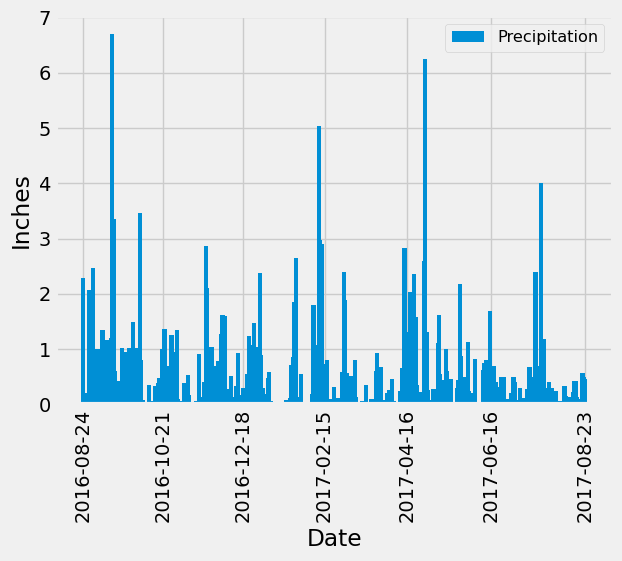

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
end_date = datetime.strptime(max_date, '%Y-%m-%d')
start_date = end_date - timedelta(days=365)
print(f"Start: {start_date}; End: {end_date}")

# Perform a query to retrieve the data and precipitation scores. Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_data = session.query(
    measurement.date,
    measurement.prcp
).filter(
    (func.strftime("%Y-%m-%d", measurement.date) >= start_date), 
    (func.strftime("%Y-%m-%d", measurement.date) <= end_date)
).all()

last_year_df = pd.DataFrame(last_year_data, columns = ['Date', 'Precipitation'])

# Sort the dataframe by date
precip_sorted_df = last_year_df.sort_values(by='Date')
precip_sorted_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precip_sorted_df.set_index('Date', inplace=True)

plt.bar(precip_sorted_df.index, precip_sorted_df['Precipitation'], width = 3, label = 'Precipitation')
plt.xlabel('Date')
plt.xticks(ticks=precip_sorted_df.index[::len(precip_sorted_df)//6], rotation = 90)
plt.ylabel('Inches')
plt.legend(fontsize='small')
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = precip_sorted_df.describe()
summary

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_total = session.query(
    func.count(
        func.distinct(measurement.station)
    )
).scalar()
station_total


9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

list = []
station_total = session.query(
    measurement.station,
    func.count(measurement.tobs).label('count')
).group_by(measurement.station).order_by(desc('count'))

for station in station_total:
    list.append((station.station, station.count))
list


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Method using Pandas
#    list_df = pd.DataFrame(list)
#    active_station = list_df.iloc[0,0]

# Method using SQLAlchemy
active_station = session.query(measurement.station).group_by(measurement.station).order_by(desc(func.count(measurement.tobs))).limit(1).scalar()

active_measurements = session.query(
    func.min(measurement.tobs).label('lowest_temp'),
    func.max(measurement.tobs).label('highest_temp'),
    func.avg(measurement.tobs).label('avg_temp')
).filter(measurement.station == active_station).one()

print(f"Lowest Temperature: {active_measurements.lowest_temp}")
print(f"Highest Temperature: {active_measurements.highest_temp}")
print(f"Average Temperature: {active_measurements.avg_temp}")


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


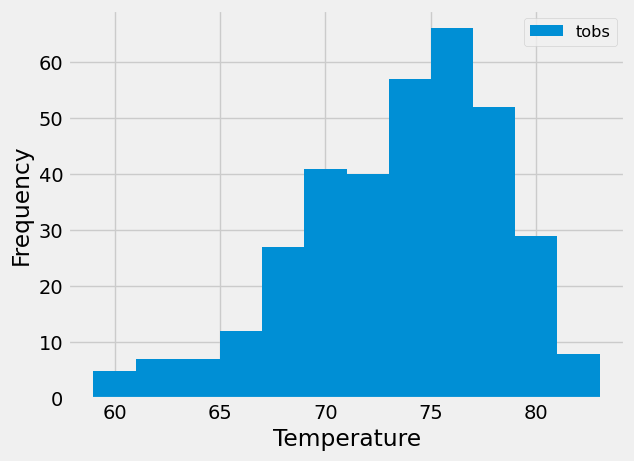

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histo_data = session.query(measurement.tobs).filter(
    (measurement.station == active_station),
    (func.strftime("%Y-%m-%d", measurement.date) >= start_date), 
    (func.strftime("%Y-%m-%d", measurement.date) <= end_date)
).all()

histo_df = pd.DataFrame(histo_data)

plt.hist(histo_df['tobs'], bins=12, label = 'tobs')
plt.legend(fontsize='small')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


# Close Session

In [24]:
# Close Session
session.close()